# 文字認識

## 目的

手書き数字を推論するAIを実装し、試してみる

## データセット

- MNISTデータセットを使用
- 70,000件の手書き数字のデータセット
- 60,000件を学習用に使用
- 10,000件をテスト用に使用
- 28x28ピクセルの白黒画像

In [2]:
import torch
import torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# MNISTデータセットのダウンロードと変換
train_dataset = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

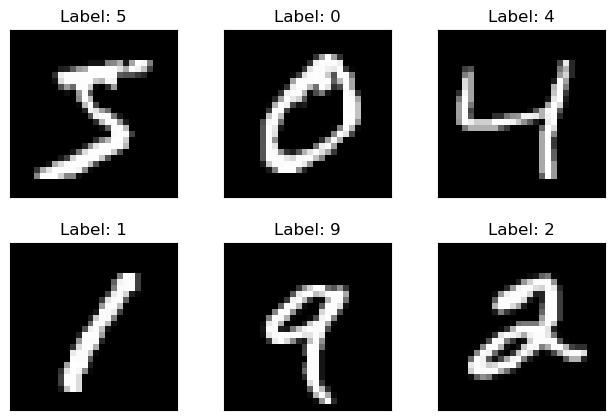

In [71]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    image_tensor = train_dataset[i][0]
    # 非正規化
    unnormalized_image = image_tensor / 2 + 0.5
    # (1, 28, 28) -> (28, 28, 1)
    permuted = unnormalized_image.permute(1, 2, 0)
    plt.imshow(permuted, cmap="gray")
    plt.title(f"Label: {train_dataset[i][1]}")
    plt.xticks([])
    plt.yticks([])

In [28]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("各サンプル数")
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print("各バッチ数")
print(len(train_loader))
print(len(test_loader))
print("各バッチサイズ（サンプル/バッチ）")
print(train_loader.batch_size)
print(test_loader.batch_size)

各サンプル数
60000
10000
各バッチ数
938
10
各バッチサイズ（サンプル/バッチ）
64
1000


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(Net, self).__init__()
        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # ドロップアウトの定義
        self.conv2_drop = nn.Dropout2d()
        # 全結合層の定義
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, debug=False):
        if debug: print(f"入力データの次元: {x.shape}")

        x = self.conv1(x)
        if debug: print(f"畳み込み１層後: {x.shape}")
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング１層後: {x.shape}")
        x = F.relu(x)

        x = self.conv2(x)
        if debug: print(f"畳み込み２層後: {x.shape}")
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング２層後: {x.shape}")
        x = F.relu(x)

        x = x.view(-1, 320)
        if debug: print(f"1次元テンソルに変換後: {x.shape}")
        x = self.fc1(x)
        if debug: print(f"全結合層１後: {x.shape}")
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        if debug: print(f"全結合層２後: {x.shape}")

        return F.log_softmax(x, dim=1)

Net()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [54]:
# パラメータの確認

# モデルのインスタンス化
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"モデルのパラメータの場所: {next(model.parameters()).device}") 

print("\n各層のパラメータ:")
total_params = 0
for name, param in model.named_parameters():
    print(f"{name}: {np.prod(param.size())}個 {param.device}に存在")
    total_params += param.numel()

print(f"\n合計パラメータ数: {total_params}個")

モデルのパラメータの場所: cpu

各層のパラメータ:
conv1.weight: 250個 cpuに存在
conv1.bias: 10個 cpuに存在
conv2.weight: 5000個 cpuに存在
conv2.bias: 20個 cpuに存在
fc1.weight: 16000個 cpuに存在
fc1.bias: 50個 cpuに存在
fc2.weight: 500個 cpuに存在
fc2.bias: 10個 cpuに存在

合計パラメータ数: 21840個


In [70]:
from torch.optim import SGD

def train(num_epochs, debug=False):
    model = Net().to(device)

    # 損失関数を定義
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)

    # ログ
    train_log_x = []
    train_log_y = []
    test_log_x = []
    test_log_y = []

    for epoch in range(num_epochs):
        if not debug: print(f"エポック: {epoch + 1}")
        for batch_index, (data, target) in enumerate(train_loader):
            model.train()
            # 勾配を初期化
            optimizer.zero_grad()
            # データをGPUに転送
            data, target = data.to(device), target.to(device)
            # モデルにデータを入力して予測を取得
            output = model(data, debug=debug)
            # 損失を計算
            loss = F.nll_loss(output, target)
            # 勾配を計算
            loss.backward()
            # パラメータの更新
            optimizer.step()

            # 100バッチごとに進捗を表示し、パラメータを保存
            if batch_index % 100 == 0 and not debug:
                data_num = batch_index * len(data)
                dataset_data_num = len(train_loader.dataset)
                total_trained = data_num + epoch * dataset_data_num
                train_log_x.append(total_trained)
                train_log_y.append(loss.item())
                print(f"バッチ:{batch_index}, データ:{data_num}/{dataset_data_num}, 損失: {loss.item()}")
                torch.save(model.state_dict(), "./model.pth")
                torch.save(optimizer.state_dict(), "./optimizer.pth")

            if debug: return

        # エポック毎にテストデータで評価
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_log_x.append(epoch * len(train_loader.dataset))
        test_log_y.append(test_loss)
        print(f"テストデータでの損失:{test_loss}, 正解率: ({int(100. * correct / len(test_loader.dataset))}%)")

    plt.figure()
    plt.plot(train_log_x, train_log_y, label="train", color="blue")
    plt.scatter(test_log_x, test_log_y, label="test", color="red")
    plt.legend(["train", "test"])
    plt.xlabel("Number of training data")
    plt.ylabel("Negative log likelihood loss")


In [69]:
train(1, debug=True)

エポック: 1
入力データの次元: torch.Size([64, 1, 28, 28])
畳み込み１層後: torch.Size([64, 10, 24, 24])
プーリング１層後: torch.Size([64, 10, 12, 12])
畳み込み２層後: torch.Size([64, 20, 8, 8])
プーリング２層後: torch.Size([64, 20, 4, 4])
1次元テンソルに変換後: torch.Size([64, 320])
全結合層１後: torch.Size([64, 50])
全結合層２後: torch.Size([64, 10])


エポック: 1
バッチ:0, データ:0/60000, 損失: 2.312612295150757
バッチ:100, データ:6400/60000, 損失: 2.1771340370178223
バッチ:200, データ:12800/60000, 損失: 1.516574740409851
バッチ:300, データ:19200/60000, 損失: 0.9571759700775146
バッチ:400, データ:25600/60000, 損失: 0.9109146595001221
バッチ:500, データ:32000/60000, 損失: 0.6114656925201416
バッチ:600, データ:38400/60000, 損失: 0.6133207082748413
バッチ:700, データ:44800/60000, 損失: 0.4329993426799774
バッチ:800, データ:51200/60000, 損失: 0.5735617280006409
バッチ:900, データ:57600/60000, 損失: 0.414008229970932
テストデータでの損失:0.21270247573852538, 正解率: (93%)
エポック: 2
バッチ:0, データ:0/60000, 損失: 0.4643525183200836
バッチ:100, データ:6400/60000, 損失: 0.8793253898620605
バッチ:200, データ:12800/60000, 損失: 0.42463555932044983
バッチ:300, データ:19200/60000, 損失: 0.2643953263759613
バッチ:400, データ:25600/60000, 損失: 0.45045942068099976
バッチ:500, データ:32000/60000, 損失: 0.4273042678833008
バッチ:600, データ:38400/60000, 損失: 0.45101138949394226
バッチ:700, データ:44800/60000, 損失: 0.35805729031562805
バッチ:800, データ:51200/60000, 損失: 0.4198392629623413
バッチ:900, データ:57600/6000

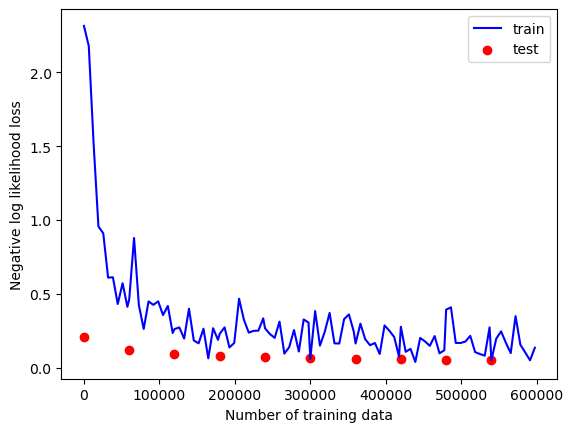

In [92]:
train(num_epochs=10)

予測結果: 2


/tmp/ipykernel_7583/2941989422.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


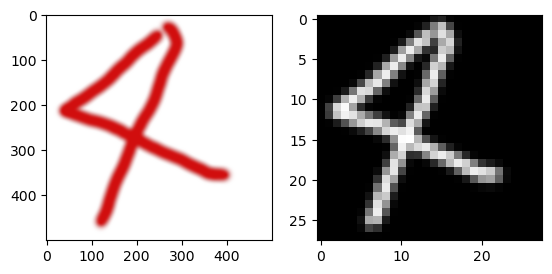

In [98]:
def predict(image_path):
    image = Image.open(image_path)
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    transform_sample = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        torchvision.transforms.Lambda(lambda x: 1 - x)
    ])
    transformed = transform_sample(image)
    ax[1].imshow(transformed.permute(1, 2, 0).squeeze(), cmap="gray")
    model = Net().to(device)
    model.load_state_dict(torch.load("./model.pth"))
    model.eval()
    prediction = model(transformed.unsqueeze(0).to(device))
    print(f"予測結果: {prediction.argmax().item()}")

predict("./sample/4.png")

予測結果: 1


/tmp/ipykernel_7583/2941989422.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


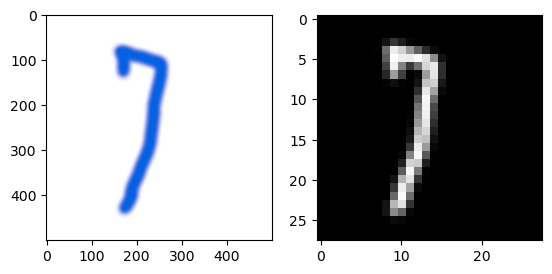

In [99]:
predict("./sample/7.png")

予測結果: 1


/tmp/ipykernel_7583/2941989422.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


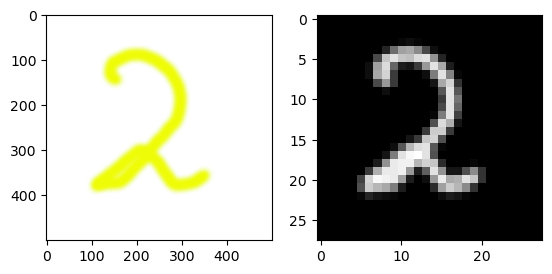

In [100]:
predict("./sample/2.png")

予測結果: 1


/tmp/ipykernel_7583/2941989422.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


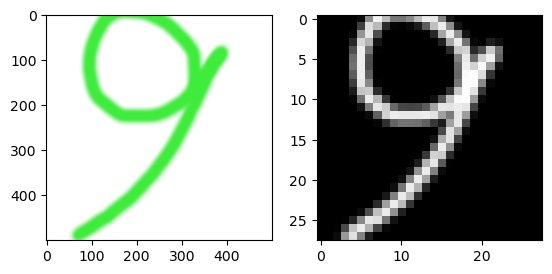

In [101]:
predict("./sample/9.png")